# NA Value Ratio Per Sensor Overtime Fluctuating

## Summary
This document gives plotting of how NA value ratio per sensor fluctuating overtime

### Imports
Imports should be grouped in the following order:
1. Magics

2. Alphabetical order
    
    A. standard librarby imports
    
    B. related 3rd party imports
    
    C. local application/library specific imports

In [1]:
# Magics
%matplotlib inline
# Do below if you want interactive matplotlib plot ()
# %matplotlib notebook

# Reload modules before executing user code
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

# Show version information for dependency modules
# https://github.com/jrjohansson/version_information
%load_ext version_information
%version_information numpy, scipy, matplotlib, pandas

Software versions
Python 3.5.2 64bit [MSC v.1900 64 bit (AMD64)]
IPython 5.1.0
OS Windows 7 6.1.7601 SP1
numpy 1.11.1
scipy 0.18.1
matplotlib 1.5.3
pandas 0.18.1
Fri Dec 09 12:30:11 2016 W. Europe Standard Time

In [1]:
# Standard library
import os
import sys
# sys.path.append('../src/')

# Third party imports
import matplotlib.pyplot as plt
import pandas as pd
import math
import seaborn as sns
sns.set() # matplotlib defaults

# Local imports

# Local imports

### Load data

In [2]:
df = pd.read_pickle('../data/wss_n1')
df.head(5)

,itapudid,max1stdetectwssc,max1stdetectwssd,max1stdetectwsse,max1stdetectwssf,eventtime
0,163540005001DC915C983,NaN,NaN,NaN,NaN,2016-12-12 13:25:31
1,163540005001DC915C983,NaN,NaN,NaN,NaN,2016-12-12 13:18:47
2,163540005001DC915C983,NaN,NaN,NaN,NaN,2016-12-12 13:36:29
3,163540005001DC915C983,NaN,NaN,NaN,NaN,2016-12-12 13:34:16
4,163540005001DC915C983,NaN,NaN,NaN,NaN,2016-12-12 13:44:09


In [3]:
# This function is used to calculate the na value each poweroffevent.
# The NA value of each poweroffevent each sensor will be 1 if that sensor shows NA value
def cal_ratio(df):
    # Calculate the sum of wss speed by each position grouped by itapudid. This results are used to determined the sensor position of the itap.
    df_sum = df.groupby('itapudid').sum().reset_index()
    # Rename the sum value for better looking
    df_sum = df_sum.rename(columns={"max1stdetectwssc": "sumc",
                                    "max1stdetectwssd": "sumd",
                                    "max1stdetectwsse": "sume",
                                    "max1stdetectwssf": "sumf"})
    df_sum = df_sum.set_index(['itapudid']) #reset the index by itapudid to get the speed of sensor by itapudid

    # Add 4 new columns sensor1, na_value1, sensor2, na_value2
    df_in = pd.DataFrame(df, columns=['itapudid', 'max1stdetectwssc',
                                      'max1stdetectwssd', 'max1stdetectwsse',
                                      'max1stdetectwssf', 'eventtime', 'sensor1',
                                      'na_value1', 'sensor2', 'na_value2'])
    df_in = df_in.reset_index(drop=True)

    # Calculate the number of na value each poweroffeevent
    for i in range(df_in.shape[0]):
        df_in.ix[i,'sensor1'] = cal_sen1(df_sum, df_in.get_value(i,'itapudid'))
        df_in.set_value(i,'na_value1', cal_na(df_in.get_value(i,'sensor1'),
                                              df_in.get_value(i,'max1stdetectwssc'),
                                              df_in.get_value(i,'max1stdetectwssd'),
                                              df_in.get_value(i,'max1stdetectwsse'),
                                              df_in.get_value(i,'max1stdetectwssf')))
        df_in.ix[i,'sensor2'] = cal_sen2(df_sum, df_in.get_value(i,'itapudid'))
        df_in.set_value(i,'na_value2', cal_na(df_in.get_value(i,'sensor2'),
                                          df_in.get_value(i,'max1stdetectwssc'),
                                          df_in.get_value(i,'max1stdetectwssd'),
                                          df_in.get_value(i,'max1stdetectwsse'),
                                          df_in.get_value(i,'max1stdetectwssf')))
    
    # Get useful features of the dataset
    df_in = df_in[['itapudid','sensor1','na_value1','sensor2','na_value2','eventtime']]    
    
    return df_in

In [4]:
# This function is used to determine sensor1 position in a single poweroffevent
def cal_sen1(df_sum, itapudid):    
    # This condition determine whether the sensors position are at C,D or not
    if ((df_sum.ix[itapudid, 'sumc'] > 0) | (df_sum.ix[itapudid, 'sumd'] > 0)):
        return 'C'
    elif (((df_sum.ix[itapudid, 'sumc'] == 0) | (df_sum.ix[itapudid, 'sumd'] == 0))) & (not((df_sum.ix[itapudid, 'sume'] > 0) | (df_sum.ix[itapudid, 'sumf'] > 0))):
        return 'C'
    elif ((math.isnan(df_sum.ix[itapudid, 'sumc']))&(math.isnan(df_sum.ix[itapudid, 'sumd']))&(math.isnan(df_sum.ix[itapudid, 'sume']))&(math.isnan(df_sum.ix[itapudid, 'sumf']))):
        return 'C'
    else:
        return 'E'

In [5]:
# This function is used to calculate how many times na value appears in a single poweroffevent per sensor
def cal_na(sensor, wssc, wssd, wsse, wssf):
    nc = 0
    
    # This condition determine whether the sensors position are at C,D or not
    if (sensor == 'C'):
        if math.isnan(wssc):
            nc += 1
    elif (sensor == 'D'):
        if math.isnan(wssd):
            nc += 1
    elif (sensor == 'E'):
        if math.isnan(wsse):
            nc += 1
    else:
        if math.isnan(wssf):
            nc += 1
    return nc

In [6]:
# This function is used to determine sensor2 position in a single poweroffevent
def cal_sen2(df_sum, itapudid):    
    # This condition determine whether the sensors position are at C,D or not
    if ((df_sum.ix[itapudid, 'sumc'] > 0) | (df_sum.ix[itapudid, 'sumd'] > 0)):
        return 'D'
    elif (((df_sum.ix[itapudid, 'sumc'] == 0) | (df_sum.ix[itapudid, 'sumd'] == 0))) & (not((df_sum.ix[itapudid, 'sume'] > 0) | (df_sum.ix[itapudid, 'sumf'] > 0))):
        return 'D'
    elif ((math.isnan(df_sum.ix[itapudid, 'sumc']))&(math.isnan(df_sum.ix[itapudid, 'sumd']))&(math.isnan(df_sum.ix[itapudid, 'sume']))&(math.isnan(df_sum.ix[itapudid, 'sumf']))):
        return 'D'
    else:
        return 'F'

In [7]:
# This function is used to plot the NA value ratio per week overtime
def plot_NA(result):
    result = result.sort_values(['eventtime']).reset_index(drop = True)
    result = result.set_index(pd.DatetimeIndex(result['eventtime']))
    result = result[['na_value1','na_value2']]
    result = result.resample("W").agg(['sum','count']).reset_index()
    result = pd.concat([result.eventtime, 
                        result.na_value1.rename(columns={'sum':'sum1', 'count':'count1'}),
                        result.na_value2.rename(columns={'sum':'sum2', 'count':'count2'})], axis=1)
    result = result.dropna(axis=0, how='any').reset_index(drop = True)
    result = pd.DataFrame(result, columns=['eventtime', 'sum1', 'count1', 'sum2', 'count2', 'Sensor1', 'Sensor2'])
    result.Sensor1 = result.sum1/result.count1
    result.Sensor2 = result.sum2/result.count2
    plt.ylabel('NA_Ratio')
    plt.xlabel('Time')
    plt.plot(result.eventtime, result.Sensor1, label='Sensor1')
    plt.plot(result.eventtime, result.Sensor2, label='Sensor2')
    plt.legend()

In [8]:
#Select the itapudid which has more than 3000 poweroffevents
result = df.groupby('itapudid').count().reset_index()
itapudid = result[result.max1stdetectwssc>3000].itapudid

C:\Users\600002464\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  after removing the cwd from sys.path.
C:\Users\600002464\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


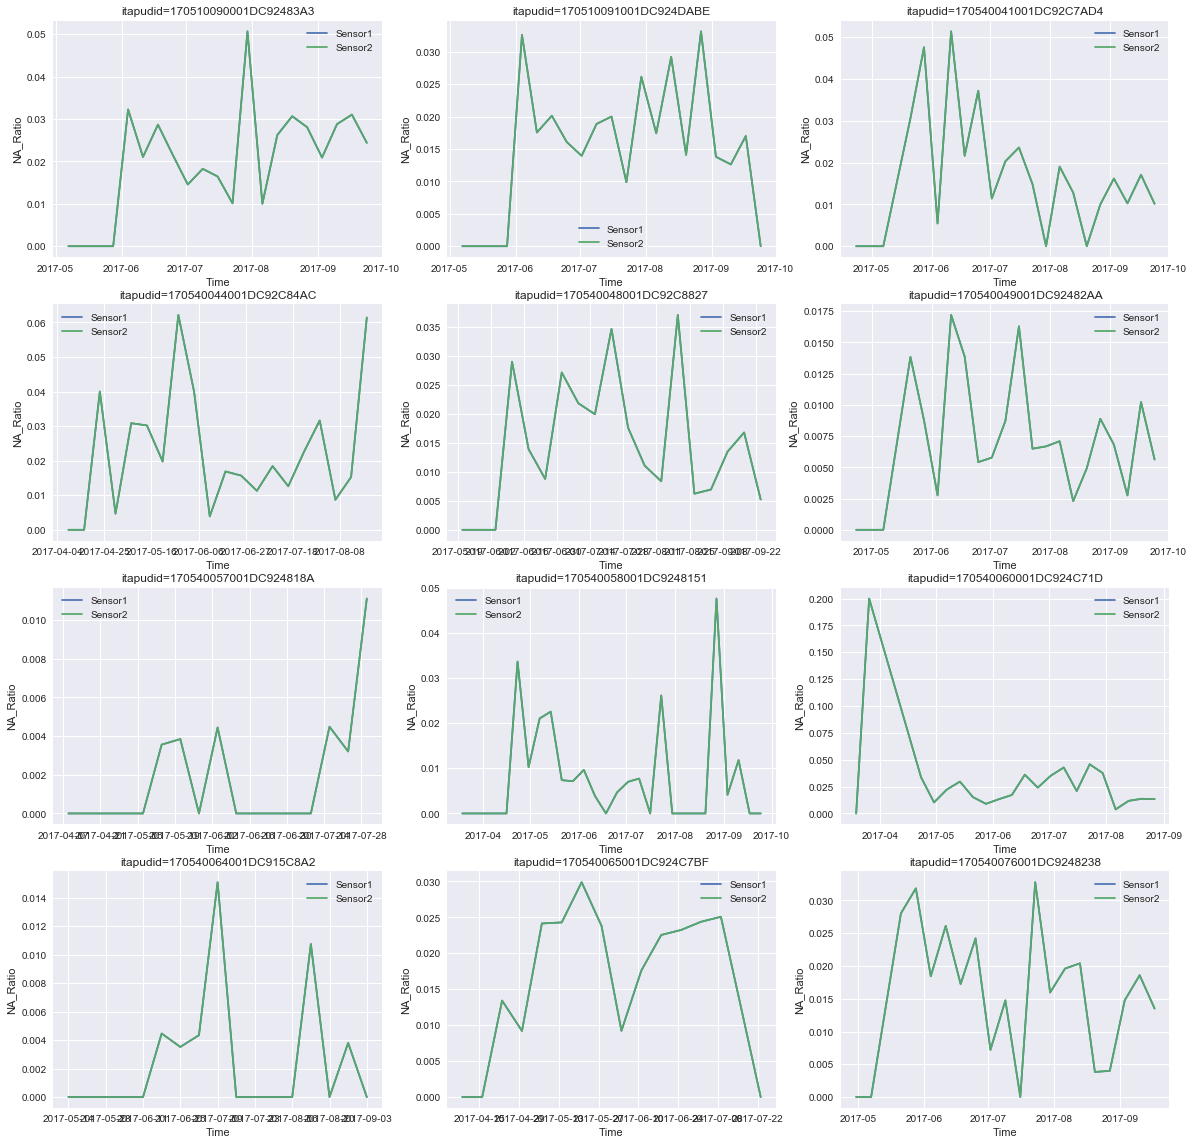

In [9]:
num = 1
plt.figure(figsize=(20, 20));
for i in itapudid:
    df1 = df[df['itapudid'] == i]
    df1 = df1[df1['eventtime']!='1970-01-01'].reset_index(drop = True)
    df_new = cal_ratio(df1)
    plt.subplot(4,3,num)
    plot_NA(df_new)
    plt.title('itapudid=%s' % (i))
    num += 1
plt.show()